![image](https://www.ewatercycle.org/assets/logo.png)

# Case study -1: Hello world. Generate forcings and run Marrmot model

This notebook demostractes how to use a model in eWatercycle by showing how to run a model on a catchment and forcing data (ERA5). This notebook also contains the steps for the preprocessing of the forcing data into model specific datasets using ESMValTool.

The model used in this notebook is:

* Marrmot M01 Collie River 1 (traditional bucket)


### Import statements
We'll be using the following modules

In [24]:
from datetime import datetime

from cftime import num2date, date2num
from esmvalcore.experimental import CFG as ESMVALTOOL_CFG
import pandas as pd
from cartopy.io import shapereader

from ewatercycle import CFG
from ewatercycle import forcing
from ewatercycle.models import MarrmotM01
from ewatercycle.observation.grdc import get_grdc_data
from ewatercycle.analysis import hydrograph

### System configuration

This notebook was run on cartesius.surfsara.nl as it has a big subset of ERA5 data files and can run models in Singularity containers. The following configuration files are available on that cluster:

* ~/.esmvaltool/config-user.yml, tells where ESMValTool can find raw ERA5 data files and shape files
* ~/.config/.ewatercycle/ewatercycle.yaml, tells ewatercycle Python package where to find GRDC data and which container image to use



### Experiment settings

In [60]:
dataset = "ERA5"
spinup_start_date = datetime(2001, 1, 1) 
start_date = datetime(2002, 1, 1)
end_date = datetime(2002, 12, 31)
shapefile = "Lorentz_Basin_Shapefiles/Merrimack/Merrimack.shp"

# GRDC station for Merrimack river
grdc_station_id = "4147380"

### Model specific settings

In [26]:
# Values based on previous calibration
maximum_soil_moisture_storage = 1999.0
initial_soil_moisture_storage = 0.9 * maximum_soil_moisture_storage

discharge_variable = "flux_out_Q"
# flux_out_Q unit conversion factor from mm/day to m3/s
conversion_mmday2m3s = 1 / (1000 * 86400)

### Derived constants

In [27]:
shape = shapereader.Reader(
    ESMVALTOOL_CFG["auxiliary_data_dir"] /shapefile
)
attr = next(shape.records())
merrimack_area = attr.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", merrimack_area)

The catchment area is: 13016500000.0


### Pre processing model forcing using ESMValTool

In [28]:
forcing_output = forcing.generate(
    model='marrmot',
    dataset=dataset,
    startyear=spinup_start_date.year,
    endyear=end_date.year,
    shapefile=shapefile
)


{'auxiliary_data_dir': PosixPath('/projects/0/wtrcycle/comparison/recipes_auxiliary_datasets'),
 'compress_netcdf': False,
 'config_developer_file': None,
 'config_file': PosixPath('/home/verhoes/.esmvaltool/config-user.yml'),
 'drs': {'CMIP5': 'default', 'CMIP6': 'default'},
 'exit_on_warning': False,
 'log_level': 'info',
 'max_parallel_tasks': 1,
 'output_dir': PosixPath('/scratch-shared/ewatercycle'),
 'output_file_type': 'png',
 'plot_dir': PosixPath('/scratch-shared/ewatercycle/recipe_marrmot_20210422_111459/plots'),
 'preproc_dir': PosixPath('/scratch-shared/ewatercycle/recipe_marrmot_20210422_111459/preproc'),
 'profile_diagnostic': False,
 'remove_preproc_dir': True,
 'rootpath': {'CMIP5': [PosixPath('/home/verhoes/cmip5_inputpath1'),
                        PosixPath('/home/verhoes/cmip5_inputpath2')],
              'CMIP6': [PosixPath('/home/verhoes/cmip6_inputpath1'),
                        PosixPath('/home/verhoes/cmip6_inputpath2')],
              'OBS6': [PosixPath('/lu

Forcing is written in a single Matlab file

In [29]:
forcing_output.recipe_output

diagnostic_daily/script:
  OutputFile('marrmot_ERA5_Merrimack_2001_2002.mat')

### Setting up the model object

To use a hydrological model, supported by ewatercycle, an object from its class must be instantiated.

In [65]:
model = MarrmotM01()

Create config file and start up container for Marrmot

In [66]:
cfg_file, cfg_dir = model.setup(
    forcing=forcing_output,
    # No need to specifiy start and end date, using dates from forcing_output
    maximum_soil_moisture_storage=maximum_soil_moisture_storage,
    initial_soil_moisture_storage=initial_soil_moisture_storage,
)
cfg_file, cfg_dir

Running docker://ewatercycle/marrmot-grpc4bmi:2020.11 singularity container on port 41755


(PosixPath('/scratch/shared/ewatercycle/marrmot_20210422_132440/marrmot-m01_config.mat'),
 PosixPath('/scratch/shared/ewatercycle/marrmot_20210422_132440'))

In [67]:
model.initialize(str(cfg_file))

Spin up for a year

In [68]:
time_units = model.time_units
spinup_end_time = date2num(start_date, time_units) - 1
while (model.time < spinup_end_time):
    model.update()

### Run model & capture discharge

In [69]:
timestamps = []
output = []

In [70]:
while (model.time < model.end_time):
    model.update()
    current_time = num2date(
        model.time,
        time_units,
        only_use_cftime_datetimes=False
    )
    timestamps.append(current_time)
    # Marrmot M01 is a lumped model, so only single value is returned
    value_in_mmday = model.get_value(discharge_variable)[0]
    # Convert from mm/day to m3/s
    value = value_in_mmday * merrimack_area * conversion_mmday2m3s
    output.append(value)

In [71]:
# Show last 10 values
list(zip(timestamps, output))[-10:]

[(real_datetime(2002, 12, 22, 12, 0), 69.05140062595778),
 (real_datetime(2002, 12, 23, 12, 0), 0.8228153161732975),
 (real_datetime(2002, 12, 24, 12, 0), 13.276754130875856),
 (real_datetime(2002, 12, 25, 12, 0), 16.494893771174766),
 (real_datetime(2002, 12, 26, 12, 0), 1413.2098826177826),
 (real_datetime(2002, 12, 27, 12, 0), 2153.0373955279038),
 (real_datetime(2002, 12, 28, 12, 0), 1.905573628400494),
 (real_datetime(2002, 12, 29, 12, 0), 0.3195046262330586),
 (real_datetime(2002, 12, 30, 12, 0), 7.983491832385312),
 (real_datetime(2002, 12, 31, 12, 0), 0.34604970900666565)]

### Clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [72]:
model.finalize()
del model.bmi

### Import GRDC observations

Read the GRDC data for the period of the experiment, for the station given above. 
If you are not on jupyter.ewatercycle.org or Cartesius, download the GRDC https://www.bafg.de/GRDC/EN/02_srvcs/21_tmsrs/riverdischarge_node.html and set the `grdc_location` field in `~/.config/.ewatercycle/ewatercycle.yaml` to your download location.

In [73]:
observations = get_grdc_data(
    station_id=grdc_station_id,
    start_date=start_date.strftime("%Y-%m-%d"),
    end_date=end_date.strftime("%Y-%m-%d"),
    data_home=CFG["grdc_location"]
)
observations

<xarray.Dataset>
Dimensions:     (time: 365)
Coordinates:
  * time        (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2002-12-31
Data variables:
    streamflow  (time) float64 56.07 54.09 48.99 50.12 ... 218.0 203.0 196.0
Attributes: (12/16)
    grdc_file_name:                /projects/0/wtrcycle/GRDC/GRDC_GCOSGTN-H_2...
    id_from_grdc:                  4147380
    file_generation_date:          2019-03-27
    river_name:                    MERRIMACK RIVER
    station_name:                  BELOW CONCORD RIVER AT LOWELL, MA
    country_code:                  US
    ...                            ...
    dataSetContent:                MEAN DAILY DISCHARGE (Q)
    units:                         m/s
    time_series:                   1923-06 - 2018-04
    no_of_years:                   96
    last_update:                   2018-09-07
    nrMeasurements:                NA

### Plot the results

Combine model output and observations into single dataframe

In [74]:
discharge = pd.DataFrame({'observation': observations.streamflow, 
                          'simulated': output}, 
                         index=timestamps)

(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

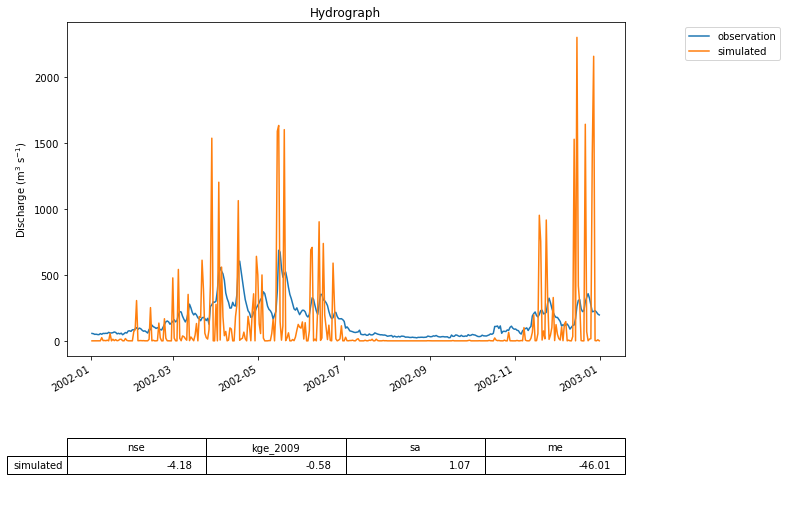

In [75]:
hydrograph(
    discharge=discharge,
    reference='observation',
)